<a href="https://colab.research.google.com/github/EruditeStranger/ML/blob/master/Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This code block downloads, installs, and imports the relevant libraries. 

!pip install numpy
!pip install scikit-learn
!pip install syft[udacity]
!pip install diffprivlib

import numpy 
import sklearn 
from sklearn import datasets
import syft 
import diffprivlib
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch import optim

     |████████████████████████████████| 348kB 3.1MB/s 
     |████████████████████████████████| 4.0MB 41.4MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 204kB 43.2MB/s 
     |████████████████████████████████| 1.8MB 31.6MB/s 
     |████████████████████████████████| 753.4MB 19kB/s 
     |████████████████████████████████| 2.1MB 37.1MB/s 
     |████████████████████████████████| 2.7MB 38.1MB/s 
     |████████████████████████████████| 1.3MB 35.9MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 110.5MB 1.2MB/s 
     |████████████████████████████████| 276kB 37.3MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 512kB 37.8MB/s 
     |████████████████████████████████| 3.8MB 38.4MB/s 
  Cr

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for diffprivlib: filename=diffprivlib-0.2.0-cp36-none-any.whl size=112367 sha256=ddb6773a4304acd398f54914032a6fb66638497493a9d3853a50ba11359ca2ff
  Stored in directory: /root/.cache/pip/wheels/b9/75/53/2b8a818e03806249bf8e51adc9820999121ba8b2566811b252
Successfully built diffprivlib


Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


/usr/local/lib/python3.6/dist-packages/diffprivlib/models/naive_bayes.py:93: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/usr/local/lib/python3.6/dist-packages/diffprivlib/models/naive_bayes.py:93: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)
/usr/local/lib/python3.6/dist-packages/diffprivlib/models/naive_bayes.py:93: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additiona

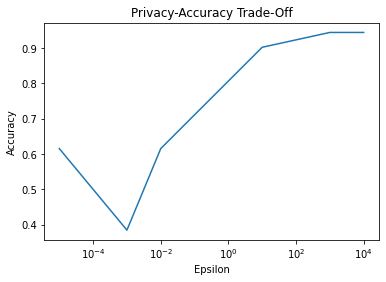

In [8]:
data, labels = datasets.load_breast_cancer(return_X_y=True)
data_train, data_test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels)

def sweep(eps=[0.00001, 0.001, 0.01, 10, 1000, 10000]):
  accuracy = [] 
  for i in range(len(eps)):
    model = diffprivlib.models.GaussianNB(epsilon=eps[i])
    model.fit(data_train, labels_train)
    accuracy.append(sklearn.metrics.accuracy_score(labels_test, model.predict(data_test)))
  return accuracy 

eps=[0.00001, 0.001, 0.01, 10, 1000, 10000] # Try changing these values to see how the accuracy plot changes! 

accuracy = sweep(eps)


plt.figure() # notice that the accuracy for each value changes every time you run it with the same values 
plt.semilogx(eps, accuracy) # this is because random noise is... well, random, so the accuracy shifts a bit based on how the data was altered each time! 
plt.title('Privacy-Accuracy Trade-Off')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()


In [9]:
hook = syft.TorchHook(torch)

bob = syft.VirtualWorker(hook, id="bob")
alice = syft.VirtualWorker(hook, id="alice")

data = torch.tensor([[0,0],[0,1],[1,0],[1,1.]], requires_grad=True)
target = torch.tensor([[0],[0],[1],[1.]], requires_grad=True)

# get pointers to training data on each worker by
# sending some training data to bob and alice
data_bob = data[0:2]
target_bob = target[0:2]

data_alice = data[2:]
target_alice = target[2:]

# Iniitalize A Toy Model
model = nn.Linear(2,1)

data_bob = data_bob.send(bob)
data_alice = data_alice.send(alice)
target_bob = target_bob.send(bob)
target_alice = target_alice.send(alice)

# organize pointers into a list
datasets = [(data_bob,target_bob),(data_alice,target_alice)]

opt = optim.SGD(params=model.parameters(),lr=0.1)

def train():
    # Training Logic
    opt = optim.SGD(params=model.parameters(),lr=0.1)
    for iter in range(10):
        
        # NEW) iterate through each worker's dataset separately
        for data,target in datasets:
            
            # NEW) send model to correct worker - either Alice or Bob
            model.send(data.location)

            # 1) Reset the optimizer so that we can develop a new model
            opt.zero_grad()

            # 2) Predict on new (unseen) data using the model from the cloud
            pred = model(data)

            # 3) See how well (or not) we did on that prediction
            loss = ((pred - target)**2).sum()

            # 4) Figure out why we performed poorly
            loss.backward()

            # 5) Update the model's weights 
            opt.step()
            
            # NEW) Get the new model, to be tested and improved on a new, separate dataset 
            model.get()

            # 6) print our progress
            print(loss.get()) # NEW) slight edit... need to call .get() on loss\
    
# federated averaging

train()

tensor(0.3051, requires_grad=True)
tensor(2.6605, requires_grad=True)
tensor(0.3738, requires_grad=True)
tensor(0.2056, requires_grad=True)
tensor(0.2887, requires_grad=True)
tensor(0.0977, requires_grad=True)
tensor(0.1852, requires_grad=True)
tensor(0.0603, requires_grad=True)
tensor(0.1187, requires_grad=True)
tensor(0.0386, requires_grad=True)
tensor(0.0770, requires_grad=True)
tensor(0.0252, requires_grad=True)
tensor(0.0505, requires_grad=True)
tensor(0.0168, requires_grad=True)
tensor(0.0336, requires_grad=True)
tensor(0.0114, requires_grad=True)
tensor(0.0226, requires_grad=True)
tensor(0.0079, requires_grad=True)
tensor(0.0154, requires_grad=True)
tensor(0.0055, requires_grad=True)
